The initial  template for this code was provided by the professor Giovanni Squillero `<giovanni.squillero@polito.it>`. All copyrights **`(c)`** are reserved to him. \
The original code can be found at [`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  


In [8]:
import logging
from itertools import combinations,permutations
from dataclasses import dataclass
import pandas as pd
import numpy as np
import geopy.distance
import random
import copy
from tqdm import tqdm
from icecream import ic
from matplotlib import pyplot as plt
import functools

logging.basicConfig(level=logging.DEBUG)

## Lab2 - TSP



In [9]:
cities = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])

In [10]:
dist_matrix = np.zeros((len(cities), len(cities)))
for c1, c2 in combinations(cities.itertuples(), 2):
    dist_matrix[c1.Index, c2.Index] = dist_matrix[c2.Index, c1.Index] = geopy.distance.geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km

In [11]:
@dataclass #decorator that generates some methods. 
class Individual:
    genome:list[int]
    fitness:float=None

def counter(fn):
    """Simple decorator for counting number of calls"""

    @functools.wraps(fn)
    def helper(*args, **kargs):
        helper.calls += 1
        return fn(*args, **kargs)

    helper.calls = 0
    return helper

@counter
def fitness(individual:Individual)->int: #cost function to minimize. It calculates the total distance of the path
    tot_cost = 0

    for c1, c2 in zip(individual.genome, individual.genome[1:]):
        tot_cost += dist_matrix[c1, c2]
    #add the distance from the last city to the first
    tot_cost += dist_matrix[individual.genome[-1], individual.genome[0]] 
    return tot_cost

def create_population(individuals_n:int, cities_n:int)->list[Individual]:
    population = []
    for _ in range(individuals_n):
        genome = list(range(1,cities_n)) #first city is always the same
        random.shuffle(genome)
        genome=[0]+genome #add the first city
        population.append(Individual(genome))
        for elem in population:
            elem.fitness = fitness(elem)
    return population

def tournament_parent_selection(population:list[Individual]):
    idx1, idx2 = np.random.choice(len(population), size=2, replace=False)
    # ic(population[idx1].fitness,population[idx2].fitness)
    population.remove(population[idx1] if population[idx1].fitness > population[idx2].fitness else population[idx2])

def rank_based_parent_selection(population:list[Individual],n_parents:int)->list[Individual]: #Rank based selection over the population.
    population.sort(key=lambda individual: individual.fitness) 
    ranks = list(range(1, len(population) + 1))  # Rank 1 = best individual
    probabilities = [1/r for r in ranks]  #Probabilities are inversely proportional to the rank
    #Normalize probabilities
    total = sum(probabilities)
    probabilities_normalized = [p/total for p in probabilities]
    parents = np.random.choice(population, n_parents, p=probabilities_normalized, replace=False) #Select n_parents in a probabilistic way
    return list(parents)
  

def crossover2P_support(parent1:Individual, parent2:Individual)->Individual:
    offspring=list()
    start=np.random.randint(0,len(cities)-1)
    end=np.random.randint(start,len(cities))
    sub_path=parent1.genome[start:end]
    out_of_sub_path=[x for x in parent2.genome if x not in sub_path]
    for i in range(0,len(cities)):
        if(i>=start and i<end):
            offspring.append(sub_path.pop(0))
        else:
            offspring.append(out_of_sub_path.pop(0))
   
    individual=Individual(offspring)
    individual.fitness=fitness(individual)
    return individual

def crossover2P(population:list[Individual])->list[Individual]: #2 Point Crossover over the entire population
    offsprings=[] 
    for i in range(0,len(population),2):
        if not i+1==len(population):
            parent1,parent2=population[i],population[i+1]
            offsprings.append(crossover2P_support(parent1,parent2))
            offsprings.append(crossover2P_support(parent2,parent1))
   

    return offsprings

#Currently not used
def mutation(population:list[Individual])->list[Individual]: #swap mutation over the entire population
    offspring=copy.deepcopy(population)
    for i in range (len(population)):
        modified_flag=False
        for _ in range (len(cities)): #each gene has a probability of being mutated
            if np.random.random()<1/len(cities): #mutation rate
                idx_city1 = np.random.randint(len(cities))
                idx_city2 = np.random.randint(len(cities))
                tmp = offspring[i].genome[idx_city1]
                offspring[i].genome[idx_city1] = offspring[i].genome[idx_city2]
                offspring[i].genome[idx_city2]=tmp
                modified_flag=True
        if modified_flag:
            offspring[i].fitness=fitness(offspring[i])
    return offspring

def InversionMutation(population:list[Individual])->list[Individual]: #Select a subset of genes and we invert the entire string in the subset.
    offspring=copy.deepcopy(population)
    for i in range (len(population)):
        low,high=random.sample(range(len(population[i].genome)), 2)
        if(low<high):
            offspring[i].genome[low:high] = reversed(offspring[i].genome[low:high])
        else: #Simulate a circular genome
            low,high=high,low
            cycle = offspring[i].genome[high:] + offspring[i].genome[:low]
            cycle = list(reversed(cycle))
            offspring[i].genome[high:] = cycle[:len(offspring[i].genome)-high]
            offspring[i].genome[:low] = cycle[len(offspring[i].genome)-high:]

        offspring[i].fitness=fitness(offspring[i])
    return offspring


#Currently not used
# def PMX_crossover(parent1:Individual, parent2:Individual)->tuple[Individual,Individual]:
#     cut_1, cut_2 = sorted(np.random.choice(len(cities), size=2, replace=False))

#     offspring1 = [None] * len(cities)
#     offspring2 = [None] * len(cities)

#     genome_p1 = parent1.genome.copy()[:-1]
#     genome_p2 = parent2.genome.copy()[:-1]

#     offspring1[cut_1:cut_2] = genome_p2[cut_1:cut_2]
#     offspring2[cut_1:cut_2] = genome_p1[cut_1:cut_2]

#     boundary_idx = list(range(0,cut_1)) + list(range(cut_2,len(cities)))
    
#     for i in boundary_idx:
#         if genome_p1[i] not in offspring1:
#             offspring1[i] = genome_p1[i]
#         else:
#             tmp = genome_p1[i]
#             j = i
#             while tmp in offspring1:
#                 j = offspring1.index(genome_p1[j])
#                 tmp = offspring2[j]
#             offspring1[i] = tmp

#     for i in boundary_idx:
#         if genome_p2[i] not in offspring2:
#             offspring2[i] = genome_p2[i]
#         else:
#             tmp = genome_p2[i]
#             j = i
#             while tmp in offspring2:
#                 j = offspring2.index(genome_p2[j])
#                 tmp = offspring1[j]
#             offspring2[i] = tmp
    
#     offspring1 = [gene for gene in offspring1 if gene is not None]
#     offspring2 = [gene for gene in offspring2 if gene is not None]
#     offspring1.append(offspring1[0])
#     offspring2.append(offspring2[0])
#     return Individual(offspring1), Individual(offspring2)

### Greedy algorithm
Simple greedy algorithm for a fast solution to the TSP problem. The algorithm starts from a random city and then moves to the nearest city. Repeats until all cities are visited.

In [12]:
def greedy_algorithm()->Individual:

    visited = np.full(len(cities), False)
    dist = dist_matrix.copy()
    city = 0
    visited[city] = True
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    return Individual(tsp)


In [13]:
e = greedy_algorithm()
fitness(e)

np.float64(4436.03176952516)

### Evolutionary Algorithm
Slow algorithm with parent selection based on ranks and dynamics operator (from hyper-modern GA): 2 points crossover + inversion mutation. Population is composed by the best (selected) individuals among parents and child (mu + lambda).

100%|██████████| 10000/10000 [00:10<00:00, 959.85it/s]
ic| best_sol.fitness: np.float64(4172.762613916409)
    best_sol_index: 6246
    fitness.calls: 505052


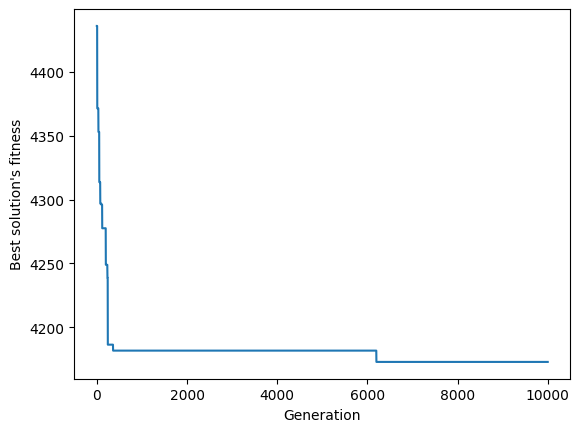

In [14]:

take_over=True #Set to False for testing
POPULATION_SIZE = 100 
population=create_population(POPULATION_SIZE, len(cities))
start=greedy_algorithm()
start.fitness=fitness(start)
start.genome=start.genome
population.append(start)
best_sol=population[0]
best_sol_index=0
history=[]
# population.sort(key=lambda i: i.fitness)
# ic("Initial population:",population)
for step in tqdm(range(10_000)):
    parents=rank_based_parent_selection(population,(POPULATION_SIZE+1)//2) #Half of the population is selected as parents
    # for _ in OFFSPRING_SIZE:
    if np.random.random()<0.2: #Random operator selection 
        offspring = crossover2P(parents)
        # population.extend(offspring)
    else:
        offspring=InversionMutation(parents) 
        # population.extend(offspring)
    population=parents+offspring # μ + λ selection
    
    population.sort(key=lambda i: i.fitness)
    population = population[:POPULATION_SIZE]
    
    #just for testing:
    if not take_over:
        take_over = all([population[0].genome == e.genome for e in population])
        if take_over:
            ic("Take over after",step,population[0].fitness)

    if(best_sol.fitness>population[0].fitness):
        best_sol=population[0]
        best_sol_index=step
    history.append(best_sol.fitness)
    # ic("After sorting:",population)
ic(best_sol.fitness,best_sol_index,fitness.calls)


#Plotting graph of the best solutions over time
plt.plot(history)
plt.ylabel('Best solution\'s fitness') 
plt.xlabel('Generation')
plt.show()
